In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import networkx as nx
import os
from sklearn.metrics import mutual_info_score
from scipy.stats import zscore
import pandas as pd
from sklearn.preprocessing import LabelEncoder
#import packages
import pandas as pd
import wget
from datetime import date
import gzip
import pandas as pd
from itertools import combinations

In [ ]:
drug_response = pd.read_csv("data/drug_response.csv", index_col=0)
drug_response = drug_response[drug_response['TCGA_DESC'] != 'UNCLASSIFIED']
# Count occurrences of each value in 'TCGA_DESC'
value_counts = drug_response['TCGA_DESC'].value_counts()
# Filter to keep only those values that appear more than 10,000 times
values_to_keep = value_counts[value_counts > 10000].index
# Filter the DataFrame to include only rows where 'TCGA_DESC' is in the values_to_keep
drug_response = drug_response[drug_response['TCGA_DESC'].isin(values_to_keep)]
models = drug_response.index.drop_duplicates()
len(models)

## Read and Preprocess data

### Transcriptomics data

In [ ]:
gene_expression = pd.read_csv("data/gene_expression.csv", index_col=0)
gene_expression = gene_expression[gene_expression.index.isin(models)]
gene_expression

#### Prepare data for inferelator

In [ ]:
tfs = pd.read_csv("data/tf.txt")
tfs = list(tfs['ID'].values)

gene_ids = pd.read_csv("data/gene_identifiers_20191101.csv")[['gene_id','ensembl_gene_id','cosmic_gene_symbol']]
gene_ids.dropna(inplace=True)
gene_ids = gene_ids[gene_ids['gene_id'].isin(gene_expression.columns)].reset_index(drop=True)

In [ ]:
gene_expression = gene_expression[list(gene_ids['gene_id'])]
mapping = dict(zip(gene_ids['gene_id'], gene_ids['cosmic_gene_symbol']))
gene_expression.rename(columns=mapping, inplace=True)
gene_expression

In [ ]:
tf_sidg = gene_ids[gene_ids['ensembl_gene_id'].isin(tfs)].reset_index(drop=True)['cosmic_gene_symbol']
tf_sidg.dropna(inplace=True)

In [ ]:
refnet = pd.read_csv("data/Human_TFTarget_GS.csv",header=None)
refnet = refnet[refnet[0].isin(gene_expression.columns)]
refnet = refnet[refnet[1].isin(gene_expression.columns)]
G = nx.from_pandas_edgelist(refnet, Source=0, Target=1)
adj_matrix = nx.to_pandas_adjacency(G, dtype=int)
refnet = adj_matrix[adj_matrix.columns.isin(tf_sidg)].T
refnet.drop_duplicates(inplace=True)
refnet

In [ ]:
cancers = drug_response['TCGA_DESC'].unique()
cancers

# Define the directory path
rnaDIR = 'data/transcriptomics/'

# Create the directory path if it doesn't exist
os.makedirs(rnaDIR, exist_ok=True)
for cancer in cancers:
    cancer_samples = list(drug_response[drug_response['TCGA_DESC'] == cancer].index)
    sub_gene_expression = gene_expression[gene_expression.index.isin(cancer_samples)]
    sub_gene_expression.to_csv(os.path.join(rnaDIR, cancer + '_gene_expression.tsv.gz'), sep='\t', index=True)

tf_sidg.to_csv(os.path.join(rnaDIR,'tf_names.tsv'), sep='\t', index=False, header=None)
refnet.to_csv(os.path.join(rnaDIR,'refnet.tsv.gz'), sep='\t', index=True)

### Proteomics Data

In [ ]:
prot_expression = pd.read_csv("data/protein_abundance.csv", index_col=0)
prot_expression = prot_expression[prot_expression.index.isin(models)]
prot_expression = prot_expression[1:10]
prot_expression


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
prot_expression = pd.DataFrame(scaler.fit_transform(prot_expression), columns=prot_expression.columns)
gene_ids = pd.read_csv("data/gene_identifiers_20191101.csv")
id_dict = dict(zip(gene_ids['uniprot_id'], gene_ids['cosmic_gene_symbol']))
prot_expression.rename(columns=id_dict, inplace=True)
prot_expression = prot_expression.loc[:, prot_expression.columns.notna()]
prot_expression

In [ ]:
# To download string network
String_network_url = "https://stringdb-static.org/download/protein.links.detailed.v11.5/9606.protein.links.detailed.v11.5.txt.gz"
String_url_file = os.path.join('data',"String_PPI.txt.gz")
#response = wget.download(String_network_url, String_url_file)
#string_info_dat = pd.read_csv(String_info_url_file, sep= ' ')
string_ppi_dat = pd.read_csv(os.path.join('data',"String_PPI.txt.gz"), sep= ' ')
string_ppi_dat = string_ppi_dat[string_ppi_dat['experimental']>700].reset_index(drop=True)
string_ppi_dat = string_ppi_dat[['protein1','protein2']]
string_ppi_dat

In [ ]:
# To download string network metadata
#String_info_url = "https://stringdb-static.org/download/protein.info.v11.5/9606.protein.info.v11.5.txt.gz"
String_info_url_file = os.path.join('data',"String_protein_info.txt.gz")
#response = wget.download(String_info_url, String_info_url_file)

#string_ppi_dat
string_info_dat = pd.read_csv(String_info_url_file, sep='\t')
string_id_dict = dict(zip(string_info_dat['#string_protein_id'], string_info_dat['preferred_name']))
string_net = string_ppi_dat.replace(string_id_dict)

In [ ]:
string_net

In [ ]:
pnet = compute_mutual_information(prot_expression)

In [ ]:


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import networkx as nx
import os
from scipy.stats import zscore
#import packages
import wget
from datetime import date
import gzip
from sklearn.metrics import normalized_mutual_info_score

# Function to compute mutual information between two columns
def mutual_information(x, y):
    return normalized_mutual_info_score(x, y)

# Compute mutual information for each pair of proteins
def compute_mutual_information(df):
    # Initialize a DataFrame to store mutual information scores
    mutual_info_df = pd.DataFrame(index=df.columns, columns=df.columns)

    # Compute mutual information for each pair of columns
    for col1 in df.columns:
        for col2 in df.columns:
            mutual_info_df.loc[col1, col2] = mutual_information(df[col1], df[col2])
    
    # Create a list to store pairs with mutual information > 0.7
    pairs = []
    for col1 in mutual_info_df.columns:
        for col2 in mutual_info_df.columns:
            if col1 != col2:
                mi_score = mutual_info_df.loc[col1, col2]
                if mi_score > 0.7:
                    pairs.append((col1, col2, mi_score))

    # Create a DataFrame for the pairwise scores
    pairwise_df = pd.DataFrame(pairs, columns=['protein1', 'protein2', 'Mutual Information'])
    pairwise_df = pairwise_df[['protein1', 'protein2']]
    
    return pairwise_df

In [ ]:
cancers = drug_response['TCGA_DESC'].unique()
cancers

# Define the directory path
protDIR = 'results/proteomics/'

# Create the directory path if it doesn't exist
os.makedirs(protDIR, exist_ok=True)
for cancer in cancers:
    cancer_samples = list(drug_response[drug_response['TCGA_DESC'] == cancer].index)
    sub_prot_expression = prot_expression[prot_expression.index.isin(cancer_samples)]
    string_net1 = string_net[string_net['protein1'].isin(sub_prot_expression.columns)]
    string_net2 = string_net1[string_net1['protein2'].isin(sub_prot_expression.columns)]
    mutual_info_matrix = compute_mutual_information(sub_prot_expression)
    protnet = pd.concat(mutual_info_matrix,string_net2)
    print(protnet)
    protnet.to_csv(os.path.join(protDIR, cancer + '_prot_net.tsv.gz'), sep='\t', index=True)


### Mutation data

In [ ]:
mut = pd.read_csv('data/mutations_all_20230202.csv')
mut = mut[mut['model_id'].isin(models)].reset_index(drop=True)
mut.index = mut['model_id'].values
mut

In [ ]:
mut.index = mut['model_id'].values
data = mut[['gene_symbol']]
data.sort_values('gene_symbol')

In [ ]:
prot_mut = mut[['gene_symbol', 'protein_mutation']]
rna_mut = mut[['gene_symbol', 'rna_mutation']]
cdna_mut = mut[['gene_symbol', 'cdna_mutation']]

In [ ]:
all_mut = pd.DataFrame(columns=['Source', 'Target'])
for mutation_table in [prot_mut, cdna_mut, rna_mut]:
    mutation_table = mutation_table[(mutation_table.iloc[:, 1] != '-') & 
                                    (mutation_table.iloc[:, 1] != 'p.?') & 
                                    (mutation_table.iloc[:, 1] != 'r.?') &
                                    (mutation_table.iloc[:, 1] != 'c.?')]
    mutation_table.columns = ['Source', 'Target']
    all_mut = pd.concat([all_mut, mutation_table], ignore_index=False)


In [ ]:
# Dictionary to hold the index pairs and their counts
pair_counts = defaultdict(int)

# Process the data
sid_groups = all_mut.groupby(all_mut.index)['Source'].apply(list)

In [ ]:
sid_groups

In [39]:
# Generate pairs and count them
for indices in sid_groups:
    for pair in combinations(indices, 2):
        print(pair)
        sorted_pair = tuple(sorted(pair))  # Ensure (A, B) and (B, A) are treated the same
        pair_counts[sorted_pair] += 1

In [ ]:
# Dictionary to hold the index pairs and their counts
pair_counts = defaultdict(int)

# Process the data
sid_groups = all_mut.groupby(all_mut.index)['Source'].apply(list)

# Generate pairs and count them
for indices in sid_groups:
    for pair in combinations(indices, 2):
        print(pair)
        sorted_pair = tuple(sorted(pair))  # Ensure (A, B) and (B, A) are treated the same
        pair_counts[sorted_pair] += 1

# Convert the dictionary to a DataFrame for easier viewing
pair_counts_df = pd.DataFrame([(pair[0], pair[1], count) for pair, count in pair_counts.items()],
                              columns=['Index1', 'Index2', 'Count'])

# Display the result
print(pair_counts_df)

In [ ]:
import pandas as pd
from itertools import combinations
from collections import defaultdict


# Function to generate unique pairs with their counts
def generate_unique_pairs(data):
    pair_counts = defaultdict(int)
    seen_pairs = set()
    
    for sid, group in data.groupby('SID'):
        indices = group['Index'].tolist()
        for pair in combinations(indices, 2):
            sorted_pair = tuple(sorted(pair))
            pair_counts[sorted_pair] += 1
            seen_pairs.add(sorted_pair)
    
    # Generate the final result with pairs and their counts
    for pair, count in pair_counts.items():
        yield pair[0], pair[1], count

# Generate the unique pairs with counts
unique_pairs_with_counts = list(generate_unique_pairs(df))

# Convert the result to a DataFrame for easier viewing
pair_counts_df = pd.DataFrame(unique_pairs_with_counts, columns=['Index1', 'Index2', 'Count'])

# Display the result
print(pair_counts_df)

In [ ]:
# Assuming drug_response, prot_mut, cdna_mut, and rna_mut are already defined
cancers = drug_response['TCGA_DESC'].unique()

# Define the directory path
mutDIR = 'results/genomics/'

# Create the directory path if it doesn't exist
os.makedirs(mutDIR, exist_ok=True)

for cancer in cancers:
    all_mut = pd.DataFrame(columns=['gene_symbol', 'mutation'])
    for mutation_table in [prot_mut, cdna_mut, rna_mut]:
        mutation_table = mutation_table[(mutation_table.iloc[:, 1] != '-') & 
                                        (mutation_table.iloc[:, 1] != 'p.?') & 
                                        (mutation_table.iloc[:, 1] != 'r.?') &
                                        (mutation_table.iloc[:, 1] != 'c.?')].reset_index(drop=True)
        mutation_table.columns = ['gene_symbol', 'mutation']
        all_mut = pd.concat([all_mut, mutation_table], ignore_index=True)
    
    # Save to CSV
    output_file = os.path.join(mutDIR, f'{cancer}_mutations.tsv.gz')
    all_mut.to_csv(output_file, sep='\t', index=False)

### PSN- Genomics

In [ ]:
net = pd.read_csv("results/integrated_PSN.csv")


# Step 1: Create the mapping from strings to numbers
string_to_number = {s: i for i, s in enumerate(set(drug_response.index))}

# Step 2: Create the reverse mapping from numbers to strings
number_to_string = {float(i): s for s, i in string_to_number.items()}

net['patient1'].replace(number_to_string, inplace=True)
net['patient2'].replace(number_to_string, inplace=True)

net = net[net['patient1'] != net['patient2']]
# Apply the function to each row
net = net[['patient1', 'patient2']].apply(sort_row, axis=1)
net.drop_duplicates(inplace=True)
net.reset_index(drop=True, inplace=True)


In [ ]:
mnet_folder = "/home/surabhi/Documents/PatStrat-Personalized-Health-Technologies-Conference-2024/results/genomics"
gnet_folder = "/home/surabhi/Documents/PatStrat-Personalized-Health-Technologies-Conference-2024/results/transcriptomics"
pnet_folder = "/home/surabhi/Documents/PatStrat-Personalized-Health-Technologies-Conference-2024/results/proteomics"

In [ ]:
idx = 1

In [ ]:
mnet_path = sorted(os.listdir(mnet_folder))[idx]
gnet_path = sorted(os.listdir(gnet_folder))[idx]
pnet_path = sorted(os.listdir(pnet_folder))[idx]

In [ ]:
net1 = pd.read_csv(os.path.join(mnet_folder, mnet_path), sep="\t")
net1 = net1[['gene_symbol', 'mutation']].apply(sort_row, axis=1)
net1 = net1.drop_duplicates()
net1['type'] = 'genomics'

In [ ]:
def sort_row(row):
    return pd.Series(sorted(row))

In [ ]:
net2 = pd.read_csv(os.path.join(pnet_folder, pnet_path), sep="\t", index_col=0)
net2

In [ ]:
net3 = pd.read_csv(os.path.join(gnet_folder, gnet_path, 'final', 'network.tsv.gz'), sep="\t")
net3 = net3[net3['precision'] > 0.7]
net3

In [ ]:
net2[net2[0].isin(net3['Target'])]

### PSN


In [ ]:
PSN_mut = pd.read_csv("results/PSN_mut_net.tsv.gz", sep='\t', index_col=0)
PSN_rna= pd.read_csv("results/PSN_rna_net.tsv.gz", sep='\t', index_col=0)
PSN_prot = pd.read_csv("results/PSN_prot_net.tsv.gz", sep='\t', index_col=0)


In [ ]:
PSN_mut['type'] = 'genomics'
PSN_rna['type'] = 'transcriptomics'
PSN_prot['type'] = 'proteomics'

In [141]:
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import networkx as nx
import os
from sklearn.metrics import mutual_info_score
from scipy.stats import zscore
import pandas as pd
from sklearn.preprocessing import LabelEncoder
#import packages
import pandas as pd
import wget
from datetime import date
import gzip
import pandas as pd
from itertools import combinations


mutDIR = "results/genomics"
protDIR = "results/proteomics"
geneDIR = "results/transcriptomics"

mutFILES = sorted(os.listdir(mutDIR))
proFILES = sorted(os.listdir(protDIR))
geneFILES = sorted(os.listdir(geneDIR))

cancer=[]
nodes = []
edges=[]

all_net = None

for idx in range(len(mutFILES)):

    mnet = pd.read_csv(os.path.join(mutDIR, mutFILES[idx]), sep = "\t")
    pnet = pd.read_csv(os.path.join(protDIR,proFILES[idx]), sep = "\t", index_col=0)
    gnet = pd.read_csv(os.path.join(geneDIR, geneFILES[idx],'final', 'network.tsv.gz'), sep = "\t")

    gnet = gnet[['target','regulator','combined_confidences','gold_standard']]
    gnet.columns = ['Target','Source','score_transcriptomics','known_regulatory_link']
    gnet['rna_edgetype'] = 'transcriptomics'
    pnet.columns = ['Source',	'Target',	'score_proteomics',	'known_PPI',	'prot_edgetype']
    mnet.columns = ['Source', 'Target']
    mnet['mut_edgetype'] = 'genomics'

    net = pd.merge(pd.merge(gnet, pnet, on=['Source', 'Target'], how='outer'), mnet, on=['Source', 'Target'], how='outer')

    net.to_csv(os.path.join("results", 'disease_net', mutFILES[idx].split('_')[0] + '.csv'), index=False)

    # Add the 'label' column to the subnet DataFrame
    subnet = net[['Source', 'Target']]
    subnet['label'] = mutFILES[idx].split('_')[0]  # Extract label from filename

    # Convert the DataFrame to an edge list with attributes
    edges_with_attributes = subnet.apply(lambda row: (row['Source'], row['Target'], {'label': row['label']}), axis=1).tolist()

    # Create a directed NetworkX graph with edge attributes
    G = nx.DiGraph()
    G.add_edges_from(edges_with_attributes)
    cancer.append(mutFILES[idx].split('_')[0])
    nodes.append(len(G.nodes))
    edges.append(len(G.edges))

    # Extract edges with attributes from the subgraph
    edges_data = []
    for u, v, data in G.edges(data=True):
        edge_info = {'Source': u, 'Target': v}
        edge_info.update(data)  # Add edge attributes like 'label'
        edges_data.append(edge_info)

    # Convert the list of edge dictionaries to a DataFrame
    df_edges = pd.DataFrame(edges_data)
    df_edges[mutFILES[idx].split('_')[0]] = 1

    # Combine all networks
    if all_net is None:
        all_net = df_edges
    else:
        all_net = pd.merge(all_net, df_edges, on=['Source', 'Target'], how='outer')
        # Handle NaN values in the labels before concatenating
        all_net['label'] = all_net['label_x'].fillna('') + "," + all_net['label_y'].fillna('')
        # Clean up the concatenated labels (e.g., remove leading/trailing commas)
        all_net['label'] = all_net['label'].str.strip(',')
        all_net = all_net.drop(['label_x', 'label_y'], axis=1)


/home/surabhi/anaconda3/envs/patstrat/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [143]:
netinfo = pd.DataFrame({'cancer':cancer, 'nodes':nodes,'edges':edges})
netinfo.to_csv("results/disease_net/netinfo.csv")
netinfo

,cancer,nodes,edges
0,ALL,25201,176965
1,BLCA,25214,274863
2,BRCA,25182,188788
3,COREAD,25188,242090
4,DLBC,25208,184665
5,ESCA,25191,201043
6,GBM,25210,201976
7,HNSC,25199,225894
8,KIRC,25207,187619
9,LAML,25210,187683


In [134]:
all_net.fillna(0, inplace=True)
all_net.to_csv("results/disease_net/integrated.csv", index=False)


In [135]:
oncogenes = pd.read_csv("data/oncogenes.csv", header=None)
oncogenes = list(oncogenes[0])

In [136]:
subdat1 = all_net[all_net['Target'].isin(oncogenes)].reset_index(drop=True)
subdat2 = all_net[all_net['Source'].isin(oncogenes)].reset_index(drop=True)
subdat = pd.concat([subdat1,subdat2])
subdat.to_csv("results/disease_net/Integrated_oncongene_subnetwork.csv", index=False)

In [138]:
sumdat = pd.DataFrame(index=['ALL', 'BLCA', 'BRCA', 'COREAD', 'DLBC', 'ESCA',
       'GBM', 'HNSC', 'KIRC', 'LAML', 'LUAD', 'MESO', 'NB', 'OV', 'PAAD',
       'SCLC', 'SKCM', 'STAD'])
for gene in oncogenes:
    A = all_net[all_net['Source'] == gene].reset_index(drop=True)
    B = all_net[all_net['Target'] == gene].reset_index(drop=True)
    oncodat = pd.concat([A,B])
    sumdat[gene] = oncodat[['ALL', 'BLCA', 'BRCA', 'COREAD', 'DLBC', 'ESCA',
        'GBM', 'HNSC', 'KIRC', 'LAML', 'LUAD', 'MESO', 'NB', 'OV', 'PAAD',
        'SCLC', 'SKCM', 'STAD']].sum(axis=0)
    
sunset_oncogenes = []
for col in sumdat.T.columns:
    sunset_oncogenes.extend(sumdat.T.sort_values(col, ascending=False)[:20].index.values)
sunset_oncogenes = list(set(sunset_oncogenes))
sumdat = sumdat[sorted(sunset_oncogenes)]

/home/surabhi/anaconda3/envs/patstrat/lib/python3.7/site-packages/ipykernel_launcher.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  # Remove the CWD from sys.path while we load stuff.


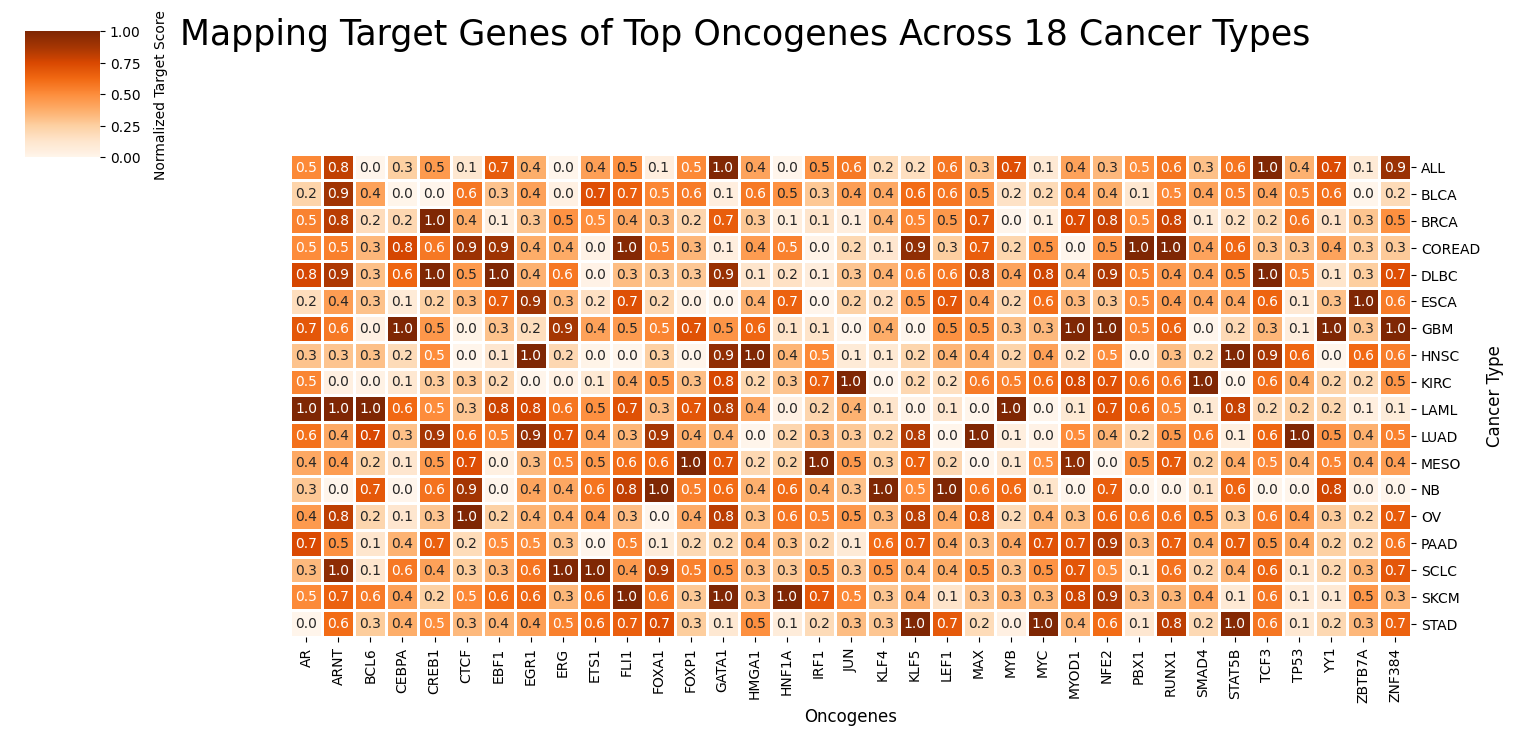

In [203]:
# Creating DataFrame
import matplotlib.cm as cm

df = pd.DataFrame(sumdat, index=sumdat.index)
df_normalized = (df - df.min()) / (df.max() - df.min())
# Plotting the heatmap
g = sns.clustermap(df_normalized, figsize=(15, 7),cmap=cm.Oranges, annot=True, fmt=".1f", linewidths=1, col_cluster=False, row_cluster=False)
plt.suptitle('Mapping Target Genes of Top Oncogenes Across 18 Cancer Types', x=0.5, y=1, ha='center', fontsize = 25)
# Add label to the legend (colorbar)
colorbar = g.cax  # get the colorbar axis

colorbar.set_ylabel("Normalized Target Score", rotation=90, labelpad=10,fontsize = 10)
g.ax_heatmap.set_xlabel("Oncogenes", fontsize=12)
g.ax_heatmap.set_ylabel("Cancer Type", fontsize=12)

plt.show()

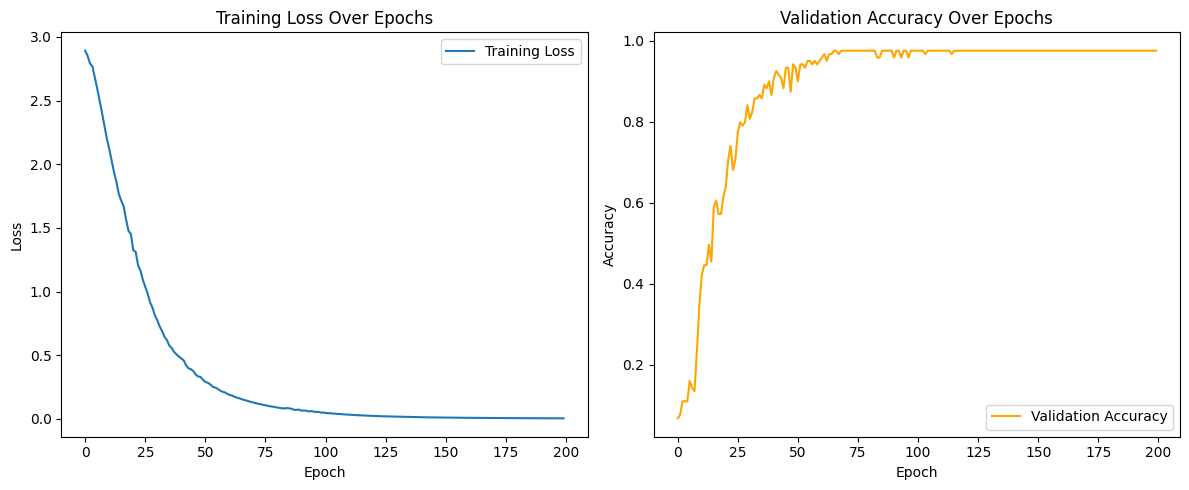

In [31]:
import numpy as np

In [32]:
def load_embeddings(embeddings_path):
    embeddings = np.load(embeddings_path)
    return embeddings


In [33]:

embeddings = load_embeddings("/home/surabhi/Documents/PatStrat-Personalized-Health-Technologies-Conference-2024/results/PatStrat_emb.npy")
embeddings

array([[ -35.56588  ,   -9.925943 ,   17.162504 , ...,   24.058193 ,
          33.14918  , -120.657684 ],
       [ -35.593365 ,   -9.87874  ,   17.15196  , ...,   24.022812 ,
          33.135365 , -120.61034  ],
       [ -35.585358 ,   -9.874819 ,   17.140263 , ...,   24.188112 ,
          33.29083  , -120.638374 ],
       ...,
       [ -20.412888 ,    0.9548111,   27.10522  , ...,    7.2685394,
           9.712925 , -103.04751  ],
       [   2.3431118,   10.068457 ,   -4.474185 , ...,  -34.05921  ,
          -8.141797 ,  -20.35061  ],
       [ -38.9835   ,  -13.231702 ,   20.943977 , ...,   17.56461  ,
          16.43098  , -127.3102   ]], dtype=float32)

In [39]:
embeddings[0]

array([ -35.56588 ,   -9.925943,   17.162504,   14.927782,  -29.166636,
        -75.426025,   23.39951 ,  -21.867817,  -35.509346,  -97.19    ,
         22.683275,  -59.841293,  -16.103401,  -17.791578,  -56.83631 ,
         24.058193,   33.14918 , -120.657684], dtype=float32)

In [45]:
subdf

,TCGA_DESC,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,PATHWAY_NAME,LN_IC50
SIDM00909,SKCM,1003,Camptothecin,TOP1,DNA replication,-1.235034
SIDM00807,BLCA,1003,Camptothecin,TOP1,DNA replication,-2.632632
SIDM01085,BLCA,1003,Camptothecin,TOP1,DNA replication,-2.963191
SIDM01160,BLCA,1003,Camptothecin,TOP1,DNA replication,-1.449138
SIDM01190,BLCA,1003,Camptothecin,TOP1,DNA replication,-2.350633
...,...,...,...,...,...,...
SIDM00214,COREAD,1003,Camptothecin,TOP1,DNA replication,-1.612538
SIDM00194,COREAD,1003,Camptothecin,TOP1,DNA replication,1.343563
SIDM00193,COREAD,1003,Camptothecin,TOP1,DNA replication,0.073547
SIDM00498,COREAD,1003,Camptothecin,TOP1,DNA replication,-2.421554


In [46]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import joblib

def load_embeddings_as_tensor(embeddings_path):
    embeddings_np = np.load(embeddings_path)
    return torch.tensor(embeddings_np, dtype=torch.float)

def main():
    # Load embeddings
    embeddings_path = 'results/PatStrat_emb.csv'
    embeddings = load_embeddings_as_tensor(embeddings_path)
    
    # Load drug response data
    drug_response = pd.read_csv("data/drug_response.csv", index_col=0)
    drug_response = drug_response[drug_response['TCGA_DESC'] != 'UNCLASSIFIED']
    # Count occurrences of each value in 'TCGA_DESC'
    value_counts = drug_response['TCGA_DESC'].value_counts()
    # Filter to keep only those values that appear more than 10,000 times
    values_to_keep = value_counts[value_counts > 10000].index
    # Filter the DataFrame to include only rows where 'TCGA_DESC' is in the values_to_keep
    drug_response = drug_response[drug_response['TCGA_DESC'].isin(values_to_keep)]
    subdf = drug_response[drug_response['DRUG_NAME'] == 'Camptothecin'][['LN_IC50']]

    node_ids = subdf.index
    responses = subdf['LN_IC50'].values
    
    # Create a dictionary to map node_ids to embeddings
    node_id_to_embedding = {node_id: embeddings[idx] for idx, node_id in enumerate(node_ids)}
    
    # Convert embeddings to a matrix format and match with responses
    X = np.array([node_id_to_embedding[node_id].numpy() for node_id in node_ids])
    y = responses
    
    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train a regression model
    regressor = Ridge(alpha=1.0)
    regressor.fit(X_train, y_train)
    
    # Make predictions
    y_pred = regressor.predict(X_test)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse:.4f}")
    
    # Save the regression model
    model_path = 'path/to/regression_model.pkl'
    joblib.dump(regressor, model_path)

if __name__ == "__main__":
    main()

IndexError: index 629 is out of bounds for dimension 0 with size 629